## 1. Import des modules

In [1]:
import pandas as pnd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D

tf.config.set_visible_devices([], 'GPU')

print("Modules importés avec succès !")

2025-11-13 15:13:28.903181: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-13 15:13:30.912839: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-13 15:13:35.307986: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-13 15:13:35.307986: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


Modules importés avec succès !


2025-11-13 15:13:36.270568: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## 2. Définition des constantes

In [2]:
# Définition de la longueur et de la largeur de l'image
LONGUEUR_IMAGE = 28
LARGEUR_IMAGE = 28

print(f"Dimensions des images : {LARGEUR_IMAGE}x{LONGUEUR_IMAGE} pixels")

Dimensions des images : 28x28 pixels


## 3. Chargement et exploration des données

In [3]:
# Chargement des images d'entraînement
observations_entrainement = pnd.read_csv('datas/fashion-mnist_train.csv')

print(f"Nombre d'observations d'entraînement : {len(observations_entrainement)}")
print(f"Nombre de colonnes : {len(observations_entrainement.columns)}")
print(f"\nPremières lignes :")
observations_entrainement.head()

Nombre d'observations d'entraînement : 60000
Nombre de colonnes : 785

Premières lignes :


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Affichage de la première image

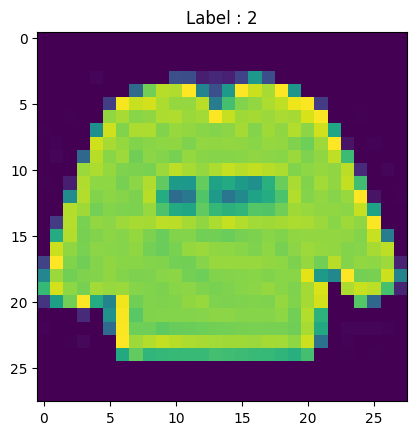

In [4]:
# On exclut la première colonne (les labels) pour constituer un tableau de pixels
X = np.array(observations_entrainement.iloc[:, 1:])

premiereImage = X[0]
premiereImage = premiereImage.reshape([LONGUEUR_IMAGE, LARGEUR_IMAGE])
plt.imshow(premiereImage)
plt.title(f"Label : {observations_entrainement.iloc[0, 0]}")
plt.show()

## 4. Préparation des données d'apprentissage

In [5]:
# On crée des catégories à l'aide du module Keras
y = keras.utils.to_categorical(np.array(observations_entrainement.iloc[:, 0]))

# Répartition des données d'entrainement en données d'apprentissage et données de validation
# 80% de donnée d'apprentissage et 20% de donnée de validation
X_apprentissage, X_validation, y_apprentissage, y_validation = train_test_split(X, y, test_size=0.2, random_state=13)

print(f"Données d'apprentissage : {X_apprentissage.shape}")
print(f"Données de validation : {X_validation.shape}")

Données d'apprentissage : (48000, 784)
Données de validation : (12000, 784)


In [6]:
# On redimensionne les images au format 28*28 et on réalise un scaling sur les données des pixels
X_apprentissage = X_apprentissage.reshape(X_apprentissage.shape[0], 
                                          LARGEUR_IMAGE, 
                                          LONGUEUR_IMAGE, 1)
X_apprentissage = X_apprentissage.astype('float32')
X_apprentissage /= 255

X_validation = X_validation.reshape(X_validation.shape[0], 
                                    LARGEUR_IMAGE, 
                                    LONGUEUR_IMAGE, 1)
X_validation = X_validation.astype('float32')
X_validation /= 255

print("Données normalisées et redimensionnées")
print(f"Shape finale des données d'apprentissage : {X_apprentissage.shape}")

Données normalisées et redimensionnées
Shape finale des données d'apprentissage : (48000, 28, 28, 1)


## 5. Préparation des données de tests

In [7]:
# Preparation des données de tests
observations_test = pnd.read_csv('datas/fashion-mnist_test.csv')
X_test = np.array(observations_test.iloc[:, 1:])
y_test = tf.keras.utils.to_categorical(np.array(observations_test.iloc[:, 0]))
X_test = X_test.reshape(X_test.shape[0], 
                        LARGEUR_IMAGE, 
                        LONGUEUR_IMAGE, 1)
X_test = X_test.astype('float32')
X_test /= 255

print(f"Données de test : {X_test.shape}")

Données de test : (10000, 28, 28, 1)


## 6. Modèle avec une seule couche de convolution

### Configuration du réseau

In [8]:
# On spécifie les dimensions de l'image d'entrée
dimentionImage = (LARGEUR_IMAGE, LONGUEUR_IMAGE, 1)

# On crée le réseau de neurones couche par couche
reseauNeurone1Convolution = Sequential()

# Ajout de la couche d'entrée
reseauNeurone1Convolution.add(Input(shape=dimentionImage))

#1- Ajout de la couche de convolution comportant
# 32 filtres de de taille 3x3 (Kernel) parcourant l'image
# Une fonction d'activation de type ReLU (Rectified Linear Activation)
# Une image d'entrée de 28px * 28 px 
reseauNeurone1Convolution.add(Conv2D(32, 
                                     kernel_size=(3, 3), 
                                     activation='relu'))

#2- Définition de la fonction de pooling avec une fenêtre de 2px sur 2 px
reseauNeurone1Convolution.add(MaxPooling2D(pool_size=(2, 2)))

#3- Ajout d'une fonction d'ignorance
reseauNeurone1Convolution.add(Dropout(0.2))

#5 - On transforme en une seule ligne
reseauNeurone1Convolution.add(Flatten())

#6 - Ajout d'un réseau de neurones composé de 128 neurones avec 
# une fonction d'activation de type ReLU
reseauNeurone1Convolution.add(Dense(128, activation='relu'))

#7 - Ajout d'un réseau de neurones composé de 10 neurones avec une 
# fonction d'activation de type softmax
reseauNeurone1Convolution.add(Dense(10, activation='softmax'))

print("Architecture du réseau à 1 couche de convolution :")
reseauNeurone1Convolution.summary()

Architecture du réseau à 1 couche de convolution :


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       692,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 693,962 (2.65 MB)

 Trainable params: 693,962 (2.65 MB)

 Non-trainable params: 0 (0.00 B)

### Compilation et apprentissage

In [9]:
reseauNeurone1Convolution.compile(loss=keras.losses.categorical_crossentropy, 
                                  optimizer=tf.keras.optimizers.Adam(), 
                                  metrics=['accuracy'])

print("Modèle compilé. Début de l'entraînement...")

Modèle compilé. Début de l'entraînement...


In [10]:
historique_apprentissage = reseauNeurone1Convolution.fit(
    X_apprentissage, 
    y_apprentissage,
    batch_size=256,
    epochs=10,
    verbose=1,
    validation_data=(X_validation, y_validation))

Epoch 1/10


2025-11-13 15:28:40.879424: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 150528000 exceeds 10% of free system memory.


188/188 ━━━━━━━━━━━━━━━━━━━━ 16s 75ms/step - accuracy: 0.8174 - loss: 0.5307 - val_accuracy: 0.8719 - val_loss: 0.3752
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 16s 75ms/step - accuracy: 0.8174 - loss: 0.5307 - val_accuracy: 0.8719 - val_loss: 0.3752
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.8773 - loss: 0.3497 - val_accuracy: 0.8830 - val_loss: 0.3298
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.8773 - loss: 0.3497 - val_accuracy: 0.8830 - val_loss: 0.3298
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - accuracy: 0.8900 - loss: 0.3092 - val_accuracy: 0.8936 - val_loss: 0.3009
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - accuracy: 0.8900 - loss: 0.3092 - val_accuracy: 0.8936 - val_loss: 0.3009
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.9004 - loss: 0.2802 - val_accuracy: 0.8981 - val_loss: 0.2895
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.9004 - loss: 0.2802 - val_accurac

### Évaluation du modèle

In [11]:
evaluation = reseauNeurone1Convolution.evaluate(X_test, y_test, verbose=0)
print('Erreur:', evaluation[0])
print('Précision:', evaluation[1])

Erreur: 0.23662006855010986
Précision: 0.9151999950408936


### Visualisation des courbes d'apprentissage

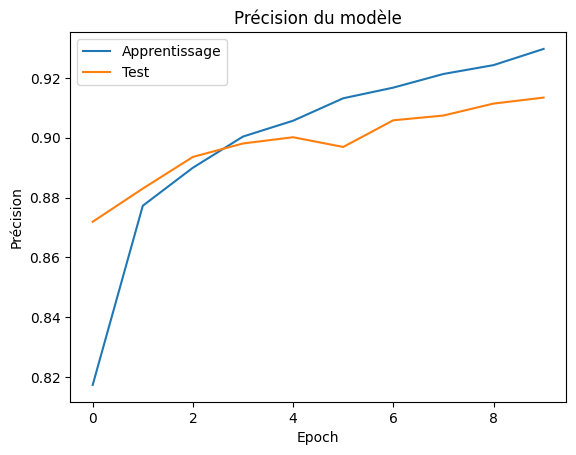

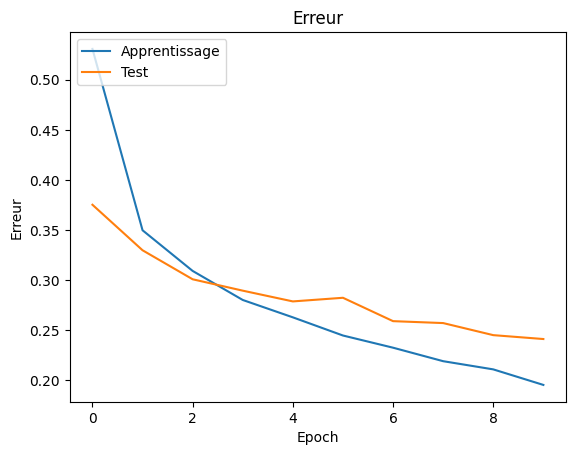

In [12]:
plt.plot(historique_apprentissage.history['accuracy'])
plt.plot(historique_apprentissage.history['val_accuracy'])
plt.title('Précision du modèle')
plt.ylabel('Précision')
plt.xlabel('Epoch')
plt.legend(['Apprentissage', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(historique_apprentissage.history['loss'])
plt.plot(historique_apprentissage.history['val_loss'])
plt.title('Erreur')
plt.ylabel('Erreur')
plt.xlabel('Epoch')
plt.legend(['Apprentissage', 'Test'], loc='upper left')
plt.show()

## 7. Augmentation du nombre de données

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

generateur_images = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=8,
    width_shift_range=0.08,
    shear_range=0.3,
    height_shift_range=0.08,
    zoom_range=0.08)

print("Générateur d'images créé")

Générateur d'images créé


In [14]:
nouvelles_images_apprentissage = generateur_images.flow(
    X_apprentissage, 
    y_apprentissage,
    batch_size=256)

nouvelles_images_validation = generateur_images.flow(
    X_validation, 
    y_validation,
    batch_size=256)

print("Générateurs d'images configurés")

Générateurs d'images configurés


### Entraînement avec augmentation des données

In [15]:
historique_apprentissage = reseauNeurone1Convolution.fit(
    nouvelles_images_apprentissage,
    steps_per_epoch=48000//256,
    epochs=50,
    validation_data=nouvelles_images_validation,
    validation_steps=12000//256,
    verbose=1 )

evaluation = reseauNeurone1Convolution.evaluate(X_test, y_test, verbose=0)

print('Erreur :', evaluation[0])
print('Précision:', evaluation[1])

Epoch 1/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 31s 163ms/step - accuracy: 0.8276 - loss: 0.4629 - val_accuracy: 0.8495 - val_loss: 0.4112
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 31s 163ms/step - accuracy: 0.8276 - loss: 0.4629 - val_accuracy: 0.8495 - val_loss: 0.4112
Epoch 2/50
  1/187 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step - accuracy: 0.8359 - loss: 0.3891

/home/vscode/.local/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8359 - loss: 0.3891 - val_accuracy: 0.8449 - val_loss: 0.4247
Epoch 3/50
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 34s 181ms/step - accuracy: 0.8498 - loss: 0.4070 - val_accuracy: 0.8558 - val_loss: 0.3854
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 34s 181ms/step - accuracy: 0.8498 - loss: 0.4070 - val_accuracy: 0.8558 - val_loss: 0.3854
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8828 - loss: 0.3510 - val_accuracy: 0.8568 - val_loss: 0.3861
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8828 - loss: 0.3510 - val_accuracy: 0.8568 - val_loss: 0.3861
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 84s 451ms/step - accuracy: 0.8560 - loss: 0.3871 - val_accuracy: 0.8626 - val_loss: 0.3735
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 84s 451ms/step - accuracy: 0.8560 - loss: 0.3871 - val_accuracy: 0.8626 - val_loss: 0.3735
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.8945 - loss: 0.3306 - 

### Sauvegarde du modèle 

In [16]:
# Sauvegarde du modèle
# Serialisation du modèle 
model_json = reseauNeurone1Convolution.to_json() 
with open("modele/modele.json", "w") as json_file:
    json_file.write(model_json)
    
# Serialisation des poids
reseauNeurone1Convolution.save_weights("modele/modele.weights.h5")
print("Modèle sauvegardé !")

Modèle sauvegardé !


## 8. Modèle avec 4 couches de convolution (Optionnel)

### Configuration du réseau

In [17]:
reseauNeurones4Convolution = Sequential()

reseauNeurones4Convolution.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=dimentionImage))
reseauNeurones4Convolution.add(BatchNormalization())
reseauNeurones4Convolution.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
reseauNeurones4Convolution.add(BatchNormalization())
reseauNeurones4Convolution.add(MaxPooling2D(pool_size=(2, 2)))
reseauNeurones4Convolution.add(Dropout(0.25))

reseauNeurones4Convolution.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
reseauNeurones4Convolution.add(BatchNormalization())
reseauNeurones4Convolution.add(Dropout(0.25))

reseauNeurones4Convolution.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
reseauNeurones4Convolution.add(BatchNormalization())
reseauNeurones4Convolution.add(MaxPooling2D(pool_size=(2, 2)))
reseauNeurones4Convolution.add(Dropout(0.25))

reseauNeurones4Convolution.add(Flatten())
reseauNeurones4Convolution.add(Dense(512, activation='relu'))
reseauNeurones4Convolution.add(BatchNormalization())
reseauNeurones4Convolution.add(Dropout(0.5))

reseauNeurones4Convolution.add(Dense(128, activation='relu'))
reseauNeurones4Convolution.add(BatchNormalization())
reseauNeurones4Convolution.add(Dropout(0.5))

reseauNeurones4Convolution.add(Dense(10, activation='softmax'))

print("Architecture du réseau à 4 couches de convolution :")
reseauNeurones4Convolution.summary()

/home/vscode/.local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Architecture du réseau à 4 couches de convolution :


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,221,546 (4.66 MB)

 Trainable params: 1,219,754 (4.65 MB)

 Non-trainable params: 1,792 (7.00 KB)

### Compilation et apprentissage (version simple)

In [18]:
reseauNeurones4Convolution.compile(loss=keras.losses.categorical_crossentropy, 
                                  optimizer=tf.keras.optimizers.Adam(), 
                                  metrics=['accuracy'])

historique_apprentissage = reseauNeurones4Convolution.fit(
    X_apprentissage, 
    y_apprentissage,
    batch_size=256,
    epochs=10,
    verbose=1,
    validation_data=(X_validation, y_validation))

Epoch 1/10


2025-11-13 16:00:02.656479: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 150528000 exceeds 10% of free system memory.


188/188 ━━━━━━━━━━━━━━━━━━━━ 101s 498ms/step - accuracy: 0.7410 - loss: 0.7482 - val_accuracy: 0.3022 - val_loss: 2.3411
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 101s 498ms/step - accuracy: 0.7410 - loss: 0.7482 - val_accuracy: 0.3022 - val_loss: 2.3411
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 94s 502ms/step - accuracy: 0.8400 - loss: 0.4477 - val_accuracy: 0.5822 - val_loss: 1.3836
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 94s 502ms/step - accuracy: 0.8400 - loss: 0.4477 - val_accuracy: 0.5822 - val_loss: 1.3836
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 98s 522ms/step - accuracy: 0.8659 - loss: 0.3730 - val_accuracy: 0.7607 - val_loss: 0.7294
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 98s 522ms/step - accuracy: 0.8659 - loss: 0.3730 - val_accuracy: 0.7607 - val_loss: 0.7294
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 104s 554ms/step - accuracy: 0.8819 - loss: 0.3333 - val_accuracy: 0.8831 - val_loss: 0.3118
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 104s 554ms/step - accuracy: 0.8819 - loss: 0.3333 -

### Évaluation

In [2]:
evaluation = reseauNeurones4Convolution.evaluate(X_test, y_test, verbose=0)
print('Erreur:', evaluation[0])
print('Précision:', evaluation[1])

NameError: name 'reseauNeurones4Convolution' is not defined

### Apprentissage avec augmentation des données 

In [1]:
historique_apprentissage = reseauNeurones4Convolution.fit(
    nouvelles_images_apprentissage,
    steps_per_epoch=48000//256,
    epochs=50,
    validation_data=nouvelles_images_validation,
    validation_steps=12000//256,
    verbose=1 )

evaluation = reseauNeurones4Convolution.evaluate(X_test, y_test, verbose=0)

print('Erreur :', evaluation[0])
print('Précision:', evaluation[1])

NameError: name 'reseauNeurones4Convolution' is not defined

### Sauvegarde du modèle avancé

In [ ]:
# Sauvegarde du modèle avancé
model_json = reseauNeurones4Convolution.to_json() 
with open("modele/modele_avance.json", "w") as json_file:
    json_file.write(model_json)
    
reseauNeurones4Convolution.save_weights("modele/modele_avance.weights.h5")
print("Modèle avancé sauvegardé !")